In [33]:
from distributed import Client, progress

In [34]:
c = Client('dscheduler:8786')

In [35]:
c.restart()

<Client: scheduler="dscheduler:8786" processes=5 cores=160>

In [36]:
import subprocess


def install_libs():
    libs = 'scikit-learn pandas matplotlib'.split()
    return subprocess.check_call('conda install -yq'.split() + libs)

install_libs()

0

In [37]:
c.run(install_libs)

{'10.112.0.5:49725': 0,
 '10.112.1.5:56560': 0,
 '10.112.2.10:57001': 0,
 '10.112.3.5:35998': 0,
 '10.112.4.4:38165': 0}

## Hyperparameter search for sklearn

In [38]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()

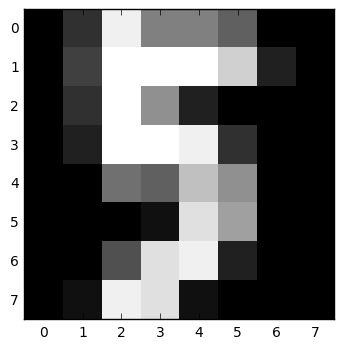

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(digits.data[35].reshape(8, 8),
           interpolation='nearest', cmap='gray');

### Sequential random parameter search

In [40]:
from sklearn.model_selection import train_test_split


def load_cv_split(split_idx):
    data = load_digits()
    splitted = train_test_split(data.data, data.target,
                                test_size=0.20,
                                random_state=split_idx)
    return split_idx, splitted

In [41]:
from time import time
from sklearn.externals.joblib import hash


def evaluate_one(model_class, parameters, cv_split):
    split_idx, (X_train, X_val, y_train, y_val) = cv_split
    t0 = time()
    model = model_class(**parameters).fit(X_train, y_train)
    training_time = time() - t0

    train_score = model.score(X_train, y_train)
    validation_score = model.score(X_val, y_val)
    
    results = {
        'split_idx': split_idx,
        'training_time': training_time,
        'train_score': train_score,
        'val_score': validation_score,
        'parameters': parameters,
        'parameters_hash': hash(parameters),
    }
    return results

In [42]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import ParameterSampler
import numpy as np
import pandas as pd

param_grid = {
    'C': np.logspace(-10, 10, 1001),
    'gamma': np.logspace(-10, 10, 1001),
    'tol': np.logspace(-4, -1, 4),
}

param_space = ParameterSampler(param_grid, 3)

cv_splits = [load_cv_split(i) for i in range(2)]

results = [evaluate_one(SVC, params, split)
           for split in cv_splits
           for params in param_space]

CPU times: user 3.25 s, sys: 0 ns, total: 3.25 s
Wall time: 3.23 s


In [43]:
pd.DataFrame.from_dict(results).drop('parameters_hash', 1)

,parameters,split_idx,train_score,training_time,val_score
0,"{'C': 4.78630092323e-08, 'gamma': 6.6069344800...",0,0.107168,0.443274,0.080556
1,"{'C': 0.346736850453, 'gamma': 100.0, 'tol': 0...",0,0.107168,0.417263,0.080556
2,"{'C': 7943282.34724, 'gamma': 3.31131121483e-0...",0,1.000000,0.061868,0.980556
3,"{'C': 13.1825673856, 'gamma': 0.00398107170553...",1,1.000000,0.473509,0.980556
4,"{'C': 158489319.246, 'gamma': 1.44543977075e-0...",1,1.000000,0.061885,0.991667
5,"{'C': 1.1481536215e-05, 'gamma': 165958690.744...",1,0.105776,0.373311,0.083333


### Scaling out with dask + distributed

In [44]:
c = Client('dscheduler:8786').restart()
n_cores = sum(c.ncores().values())
n_cores

160

In [45]:
from dask import delayed


param_space = ParameterSampler(param_grid, n_cores * 10)

cv_splits = [delayed(load_cv_split)(i) for i in range(3)]
        
delayed_evaluations = [delayed(evaluate_one)(SVC, params, split)
                       for split in cv_splits
                       for params in param_space]

In [46]:
delayed_evaluations[:5]

[Delayed('evaluate_one-42ec3019-71d8-469f-9c8c-fb1725d69241'),
 Delayed('evaluate_one-0c4aec2b-6051-42aa-bccb-d98fd689ff46'),
 Delayed('evaluate_one-cd2875f3-cb5e-4650-abdc-123de263841e'),
 Delayed('evaluate_one-59f92b51-1d35-4d7b-903a-9e3e84dbf2e2'),
 Delayed('evaluate_one-532d0104-1237-4a59-ba0f-51669aff4856')]

In [47]:
all_results = c.compute(delayed_evaluations)

In [48]:
progress(all_results)

In [49]:
results = c.gather([f for f in all_results if f.done()])
results = pd.DataFrame.from_dict(results)
results.describe()

,split_idx,train_score,training_time,val_score
count,4800.000000,4800.000000,4800.000000,4800.000000
mean,1.000000,0.539631,0.526947,0.248602
std,0.816582,0.443539,0.193641,0.343576
min,0.000000,0.105776,0.049600,0.077778
25%,0.000000,0.105776,0.538719,0.077778
50%,1.000000,0.107168,0.583392,0.080556
75%,2.000000,1.000000,0.628447,0.083333
max,2.000000,1.000000,1.068997,0.994444


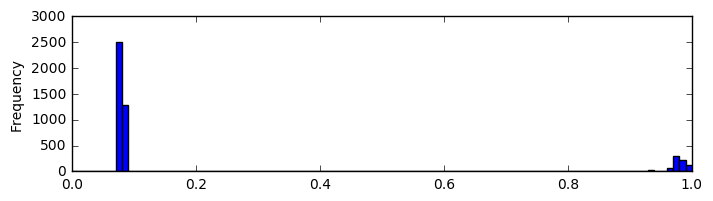

In [50]:
plt.figure(figsize=(8, 2))
bins = np.linspace(0, 1, 100)
results['val_score'].plot(kind='hist', bins=bins);

### Aggregation of scores across CV folds

In [51]:
mean_evaluations = results.groupby('parameters_hash').agg({
    'train_score': np.mean,
    'val_score': np.mean,
    'training_time': np.mean,
}).reset_index()

all_parameters = pd.DataFrame.from_dict(list(results['parameters']))
all_parameters['parameters_hash'] = results['parameters_hash']

evaluations = (
    mean_evaluations
    .merge(all_parameters)
    .drop(['parameters_hash'], axis=1)
)
top10 = evaluations.sort_values(
    by='val_score', ascending=False).head(10)
top10

,val_score,train_score,training_time,C,gamma,tol
61,0.994444,1.000000,0.311204,1.148154e+07,1.737801e-03,0.0010
3087,0.994444,1.000000,0.275013,2.630268e+00,1.513561e-03,0.0010
1699,0.991667,1.000000,0.189089,7.585776e+09,9.120108e-04,0.0010
118,0.991667,1.000000,0.058707,4.570882e+07,2.511886e-07,0.1000
1760,0.991667,1.000000,0.060062,5.495409e+07,6.918310e-09,0.1000
1748,0.991667,0.988866,0.099104,5.011872e+03,1.000000e-07,0.0001
1737,0.991667,1.000000,0.141979,1.584893e+04,6.606934e-04,0.0001
1710,0.991667,1.000000,0.131292,5.754399e+00,5.754399e-04,0.0010
4370,0.991667,1.000000,0.081536,1.819701e+09,3.467369e-04,0.1000
1287,0.991667,0.988866,0.067960,1.659587e+03,3.801894e-07,0.1000


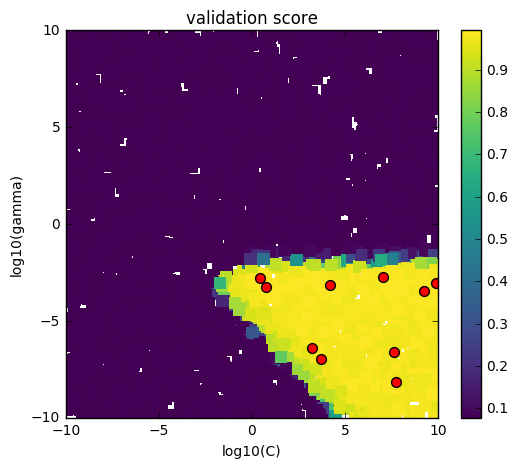

In [52]:
import matplotlib.pyplot as plt

def plot_param_map(df, target, title):
    plt.xlabel('log10(C)')
    plt.ylabel('log10(gamma)')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(np.log10(df['C']), np.log10(df['gamma']),
                c=target,
                marker='s', edgecolors='none',
                s=80, alpha=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)

plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['val_score'],
               'validation score')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

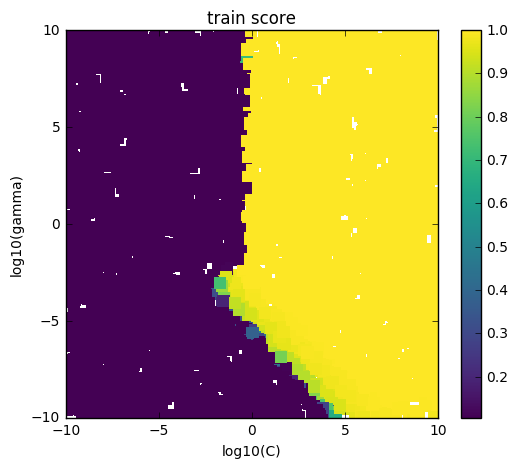

In [53]:
plt.figure(figsize=(6, 5))
plot_param_map(evaluations, evaluations['train_score'], 'train score')

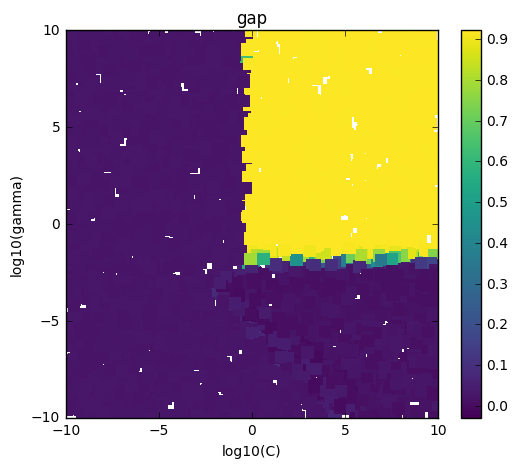

In [54]:
plt.figure(figsize=(6, 5))
gap = evaluations['train_score'] - evaluations['val_score']
plot_param_map(evaluations, gap, 'gap')

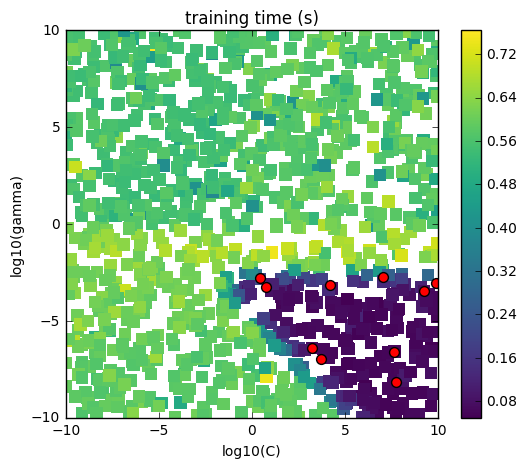

In [55]:
plt.figure(figsize=(6, 5))
high_tol = evaluations[evaluations['tol'] == 0.1]

plot_param_map(high_tol, high_tol['training_time'], 'training time (s)')
plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
            c='r', s=50);

## Scaling down

### Single local python process, multiple threads

In [56]:
import dask
%time _ = dask.compute(*delayed_evaluations[:10])

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 996 ms


### Single local python process, no parallelism

In [57]:
from dask.async import get_sync

%time _ = dask.compute(*delayed_evaluations[:10], get=get_sync)

CPU times: user 5.09 s, sys: 0 ns, total: 5.09 s
Wall time: 5.07 s


In [58]:
%prun _ = dask.compute(*delayed_evaluations[:10], get=get_sync)